# Fitting a small neural network for T = f(z)
## Using the SIREN model
Using a compact feedforward network in PyTorch to interpolate the provided (z, T) points.


In [51]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.manual_seed(0)
%matplotlib inline


In [52]:
# data table converted to numpy and torch
data = np.array([
    0, 22.8,
    2.3, 22.8,
    4.9, 22.8,
    9.1, 20.6,
    13.7, 13.9,
    18.3, 11.7,
    22.9, 11.1,
    27.2, 11.1,
]).astype(np.float32)

z = torch.tensor(data[0::2]).unsqueeze(1)
T = torch.tensor(data[1::2]).unsqueeze(1)

print('z values:', z.squeeze().numpy())
print('T values:', T.squeeze().numpy())


z values: [ 0.   2.3  4.9  9.1 13.7 18.3 22.9 27.2]
T values: [22.8 22.8 22.8 20.6 13.9 11.7 11.1 11.1]


z_fine values: [ 0.        1.431579  2.863158  4.294737  5.726316  7.157895  8.589474
 10.021053 11.452632 12.884211 14.31579  15.747369 17.178947 18.610527
 20.042107 21.473684 22.905264 24.336843 25.768421 27.2     ]
T_fine values: [22.79999924 22.76900044 22.82360948 22.83727563 22.68092284 22.18405444
 21.14232136 19.38273604 17.14210495 14.93852225 13.28511018 12.35167789
 11.89598589 11.6519092  11.43697521 11.24673846 11.09956043 11.01380343
 11.00782942 11.10000038]


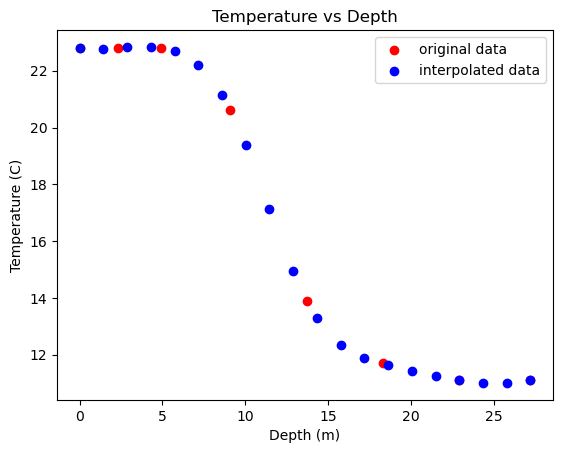

In [53]:
import scipy.interpolate as spi
# increase the number of points by interpolation
z_fine = torch.linspace(0, 27.2, steps=20).unsqueeze(1)   
T_fine = torch.tensor(spi.interp1d(z.squeeze().numpy(), T.squeeze().numpy(), kind='cubic')(z_fine.squeeze().numpy())).unsqueeze(1)
print('z_fine values:', z_fine.squeeze().numpy())
print('T_fine values:', T_fine.squeeze().numpy()) 

# plot the new data and the old data together
plt.scatter(z.numpy(), T.numpy(), label='original data', color='red')
plt.scatter(z_fine.numpy(), T_fine.numpy(), label='interpolated data', color='blue')
plt.xlabel('Depth (m)')
plt.ylabel('Temperature (C)')
plt.title('Temperature vs Depth')
plt.legend()
plt.show()

In [54]:
len(z_fine), len(z)

(20, 8)

In [55]:
# replace the original data with the fine data but replace with float 32
useInterpolated_data = True
if useInterpolated_data:
    z_raw = z_fine.float()
    T = T_fine.float()
else:
    z_raw = z.float()
    T = T.float()
# normalize inputs to [-1, 1] for SIREN stability
z_min = z_raw.min()
z_max = z_raw.max()
z_scale = (z_max - z_min) / 2.0
z_center = (z_max + z_min) / 2.0
z = (z_raw - z_center) / z_scale


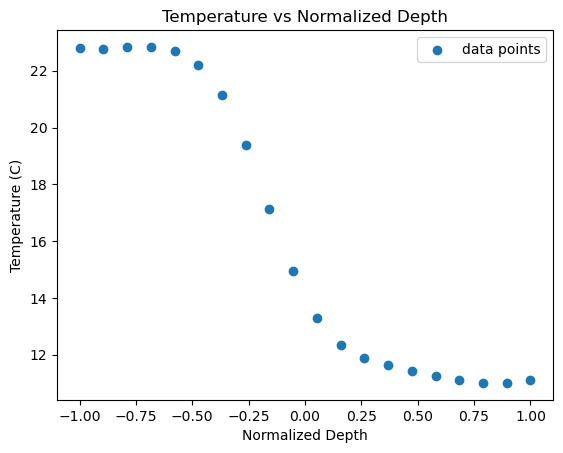

In [56]:
# plot the data after normalization
plt.scatter(z.numpy(), T.numpy(), label='data points')
plt.xlabel('Normalized Depth')
plt.ylabel('Temperature (C)')
plt.title('Temperature vs Normalized Depth')
plt.legend()
plt.show()

In [57]:
# SIREN model: sine activations with SIREN initialization
class Sine(nn.Module):
    def __init__(self, omega0=15.0):
        super().__init__()
        self.omega0 = omega0

    def forward(self, x):
        return torch.sin(self.omega0 * x)


def siren_init(layer, omega0, is_first):
    with torch.no_grad():
        if is_first:
            # First layer uses a different initialization scale
            layer.weight.uniform_(-1.0 / layer.in_features, 1.0 / layer.in_features)
        else:
            bound = (6.0 / layer.in_features) ** 0.5 / omega0
            layer.weight.uniform_(-bound, bound)


class SirenNet(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, omega0=15.0):
        super().__init__()
        layers = []

        first = nn.Linear(in_features, hidden_features)
        siren_init(first, omega0, is_first=True)
        layers.append(first)
        layers.append(Sine(omega0))

        for _ in range(hidden_layers):
            lin = nn.Linear(hidden_features, hidden_features)
            siren_init(lin, omega0, is_first=False)
            layers.append(lin)
            layers.append(Sine(omega0))

        final = nn.Linear(hidden_features, out_features)
        siren_init(final, omega0, is_first=False)
        layers.append(final)

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


model = SirenNet(in_features=1, hidden_features=32, hidden_layers=2, out_features=1, omega0=11.0)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model


SirenNet(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): Sine()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Sine()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Sine()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [58]:
# training loop
num_epochs = 1000
reg_lambda = 1e-5
loss_history = []

for epoch in range(num_epochs):
    pred = model(z)
    mse_loss = loss_fn(pred, T)
    l2_penalty = 0.0
    for param in model.parameters():
        if param.ndim > 1:
            l2_penalty = l2_penalty + param.pow(2).mean()
    loss = mse_loss + reg_lambda * l2_penalty

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch + 1}: loss = {loss.item():.4f}')


Epoch 100: loss = 187.3548
Epoch 200: loss = 121.8638
Epoch 300: loss = 79.6394
Epoch 400: loss = 53.8541
Epoch 500: loss = 38.1573
Epoch 600: loss = 26.9345
Epoch 700: loss = 18.7803
Epoch 800: loss = 12.8871
Epoch 900: loss = 8.7462
Epoch 1000: loss = 5.8269


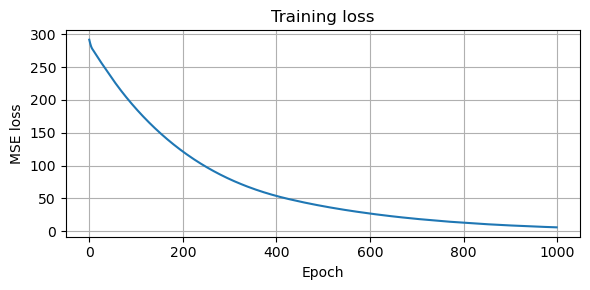

In [59]:
plt.figure(figsize=(6, 3))
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.title('Training loss')
plt.grid(True)
plt.tight_layout()
plt.show()


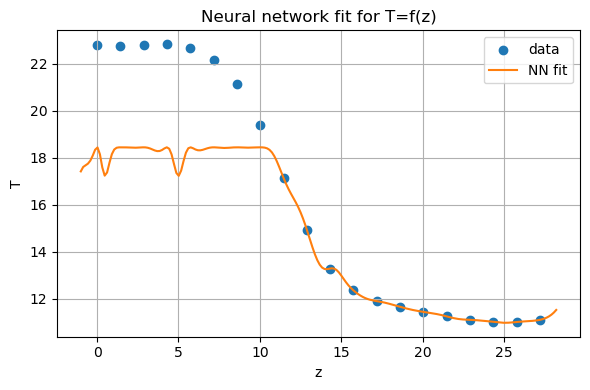

Predictions on training points:
z=  0.0, T=22.80, predicted=18.45
z=  1.4, T=22.77, predicted=18.45
z=  2.9, T=22.82, predicted=18.45
z=  4.3, T=22.84, predicted=18.45
z=  5.7, T=22.68, predicted=18.45
z=  7.2, T=22.18, predicted=18.45
z=  8.6, T=21.14, predicted=18.45
z= 10.0, T=19.38, predicted=18.45
z= 11.5, T=17.14, predicted=17.14
z= 12.9, T=14.94, predicted=14.94
z= 14.3, T=13.29, predicted=13.29
z= 15.7, T=12.35, predicted=12.35
z= 17.2, T=11.90, predicted=11.90
z= 18.6, T=11.65, predicted=11.65
z= 20.0, T=11.44, predicted=11.44
z= 21.5, T=11.25, predicted=11.25
z= 22.9, T=11.10, predicted=11.10
z= 24.3, T=11.01, predicted=11.01
z= 25.8, T=11.01, predicted=11.01
z= 27.2, T=11.10, predicted=11.10


In [60]:
with torch.no_grad():
    z_plot_raw = torch.linspace(z_raw.min() - 1, z_raw.max() + 1, 200).unsqueeze(1)
    z_plot = (z_plot_raw - z_center) / z_scale
    T_pred_curve = model(z_plot)
    T_pred_train = model(z)

plt.figure(figsize=(6, 4))
plt.scatter(z_raw.numpy(), T.numpy(), color='tab:blue', label='data')
plt.plot(z_plot_raw.numpy(), T_pred_curve.numpy(), color='tab:orange', label='NN fit')
plt.xlabel('z')
plt.ylabel('T')
plt.title('Neural network fit for T=f(z)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print('Predictions on training points:')
for zi, ti, pi in zip(z_raw, T, T_pred_train):
    print(f'z={zi.item():5.1f}, T={ti.item():5.2f}, predicted={pi.item():5.2f}')


In [61]:
# predict the temperature at z = 15
z_test_raw = torch.tensor([[15.0]])
z_test = (z_test_raw - z_center) / z_scale
with torch.no_grad():
    T_test_pred = model(z_test)
print(f'Predicted temperature at z=15: T={T_test_pred.item():.2f}')


Predicted temperature at z=15: T=12.98
